In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.interpolate import CubicSpline


## Bootstrap Function

In [93]:
def compute_ytm(price, coupon_rate, maturity):
    face_value = 100
    num_periods = max(1, int(round(maturity * 2)))  # Converting years to semi-annual periods, ensure at least 1
    coupon = (coupon_rate / 100) * face_value / 2  # Semi-annual coupon payment

    # Handle immediate maturity cases - only 1 coupon, at maturity
    if maturity <= 0.5:
        return ((face_value + coupon - price) / price) * 100


    def bond_price_eq(y):
        return sum(coupon / (1 + y / 2) ** t for t in range(1, num_periods + 1)) + \
               face_value / (1 + y / 2) ** num_periods - price


    ytm_solution = fsolve(bond_price_eq, 0.05)  # Initial guess of 5% yield
    return ytm_solution[0] * 100  # Convert to percentage

# Compute YTM for each day
ytm_curves = {}


In [94]:
def compute_spot_rates(bonds):
    spot_rates = []

    for i, (price, coupon_rate, maturity) in enumerate(bonds):
        face_value = 100
        num_periods = max(1, int(round(maturity * 2)))  # Converting years to semi-annual periods, ensure at least 1
        coupon = (coupon_rate / 100) * face_value / 2  # Semi-annual coupon payment

        if i == 0:  # Zero-coupon bond (first bond in bootstrapping)
            S_n = np.log(face_value / price) / maturity
        else:
            # Solving iteratively using previously computed spot rates
            def spot_rate_eq(S_n):
                total = sum(coupon / (1 + spot_rates[j] / 2) ** ((j+1) * 2) for j in range(i))
                return total + (face_value + coupon) / (1 + S_n / 2) ** num_periods - price

            # Using the previous spot rate as an initial guess for better stability
            initial_guess = spot_rates[-1] / 100 if spot_rates else 0.05
            S_n = fsolve(spot_rate_eq, initial_guess)[0]  # Solve for spot rate

        spot_rates.append(S_n * 100)  # Convert to %

    return spot_rates

def compute_forward_rates(spot_rates, maturities):
    forward_rates = []
    for t in range(len(spot_rates) - 1):
        F_t = ((1 + spot_rates[t+1] / 100) ** (t+1) / (1 + spot_rates[t] / 100) ** t) - 1
        forward_rates.append(F_t * 100)  # Convert to %
    return forward_rates


# Compute forward and spot rates for each day
spot_curves = {}
forward_curves = {}

##Bond Price Data

In [95]:
bond_data_by_day = {
    "Jan 6": [(100.02, 3.75, 0.07), (99.72, 1.25, 0.15), (101.615, 4.50, 1.07), (96.985, 0.25, 1.15),
               (100.165, 3.00, 2.07), (96.66, 1.25, 2.15), (101.955, 3.50, 3.15), (97.23, 2.00, 3.40),
               (104.225, 4.00, 4.15), (97.665, 2.25, 4.40)],
    "Jan 7": [(100.02, 3.75, 0.07), (99.72, 1.25, 0.15), (101.605, 4.50, 1.07), (96.99, 0.25, 1.15),
               (100.19, 3.00, 2.07), (96.635, 1.25, 2.15), (101.92, 3.50, 3.15), (97.16, 2.00, 3.40),
               (104.135, 4.00, 4.15), (97.54, 2.25, 4.40)],
    "Jan 8": [(100.035, 3.75, 0.07), (99.725, 1.25, 0.15), (101.57, 4.50, 1.07), (96.97, 0.25, 1.15),
               (100.135, 3.00, 2.07), (96.605, 1.25, 2.15), (101.815, 3.50, 3.15), (97.065, 2.00, 3.40),
               (103.98, 4.00, 4.15), (97.385, 2.25, 4.40)],
    "Jan 9": [(100.035, 3.75, 0.07), (99.74, 1.25, 0.15), (101.575, 4.50, 1.07), (96.985, 0.25, 1.15),
               (100.13, 3.00, 2.07), (96.585, 1.25, 2.15), (101.77, 3.50, 3.15), (96.99, 2.00, 3.40),
               (103.875, 4.00, 4.15), (97.26, 2.25, 4.40)],
    "Jan 10": [(100.035, 3.75, 0.07), (99.74, 1.25, 0.15), (101.595, 4.50, 1.07), (97.00, 0.25, 1.15),
                (100.125, 3.00, 2.07), (96.625, 1.25, 2.15), (101.825, 3.50, 3.15), (97.03, 2.00, 3.40),
                (103.945, 4.00, 4.15), (97.325, 2.25, 4.40)],
    "Jan 13": [(100.00, 3.75, 0.07), (99.735, 1.25, 0.15), (101.44, 4.50, 1.07), (96.89, 0.25, 1.15),
                (99.865, 3.00, 2.07), (96.375, 1.25, 2.15), (101.47, 3.50, 3.15), (96.68, 2.00, 3.40),
                (103.47, 4.00, 4.15), (96.85, 2.25, 4.40)],
    "Jan 14": [(100.03, 3.75, 0.07), (99.735, 1.25, 0.15), (101.38, 4.50, 1.07), (96.845, 0.25, 1.15),
                (99.745, 3.00, 2.07), (96.265, 1.25, 2.15), (101.21, 3.50, 3.15), (96.43, 2.00, 3.40),
                (103.135, 4.00, 4.15), (96.495, 2.25, 4.40)],
    "Jan 15": [(100.03, 3.75, 0.07), (99.74, 1.25, 0.15), (101.36, 4.50, 1.07), (96.81, 0.25, 1.15),
                (99.715, 3.00, 2.07), (96.195, 1.25, 2.15), (101.095, 3.50, 3.15), (96.275, 2.00, 3.40),
                (102.955, 4.00, 4.15), (96.33, 2.25, 4.40)],
    "Jan 16": [(100.00, 3.75, 0.07), (99.755, 1.25, 0.15), (101.42, 4.50, 1.07), (96.89, 0.25, 1.15),
                (99.93, 3.00, 2.07), (96.375, 1.25, 2.15), (101.33, 3.50, 3.15), (96.56, 2.00, 3.40),
                 (103.325, 4.00, 4.15), (96.65, 2.25, 4.40)],
    "Jan 17": [(100.03, 3.75, 0.07), (99.81, 1.25, 0.15), (101.52, 4.50, 1.07), (97.04, 0.25, 1.15),
                (100.145, 3.00, 2.07), (96.615, 1.25, 2.15), (101.095, 3.50, 3.15), (96.275, 2.00, 3.40),
                (102.955, 4.00, 4.15), (96.33, 2.25, 4.40)],
}

## Plotting the yield curve

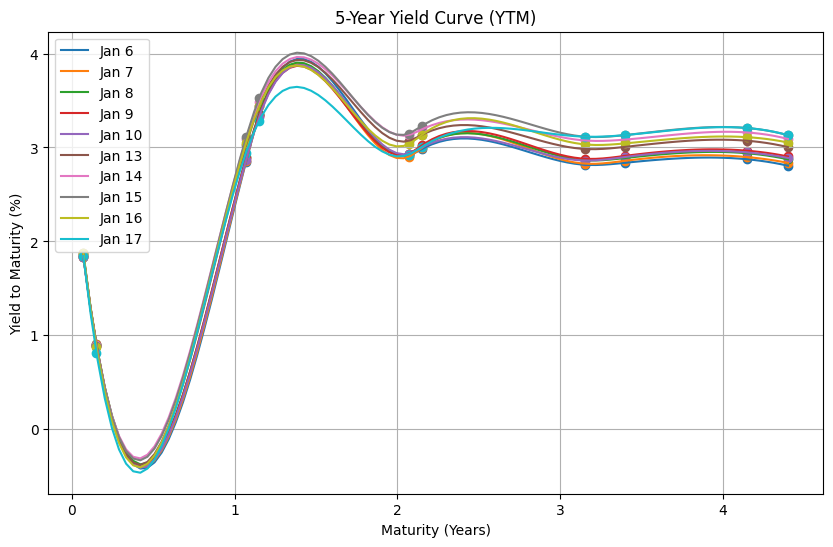

In [96]:
for day, bonds in bond_data_by_day.items():
    maturities = []
    ytm_values = []
    for price, coupon_rate, maturity in bonds:
        ytm = compute_ytm(price, coupon_rate, maturity)
        maturities.append(maturity)
        ytm_values.append(ytm)
    ytm_curves[day] = (maturities, ytm_values)

# Plot yield curves for each day with cubic spline interpolation to smoothen out the curve.
plt.figure(figsize=(10, 6))

for day, (maturities, ytms) in ytm_curves.items():
    sorted_indices = np.argsort(maturities)
    sorted_maturities = np.array(maturities)[sorted_indices]
    sorted_ytms = np.array(ytms)[sorted_indices]

    cs = CubicSpline(sorted_maturities, sorted_ytms)
    smooth_x = np.linspace(min(sorted_maturities), max(sorted_maturities), 100)
    smooth_y = cs(smooth_x)

    plt.plot(smooth_x, smooth_y, linestyle='-', label=day)
    plt.scatter(sorted_maturities, sorted_ytms, marker='o')

plt.xlabel("Maturity (Years)")
plt.ylabel("Yield to Maturity (%)")
plt.title("5-Year Yield Curve (YTM)")
plt.legend()
plt.grid()
plt.show()


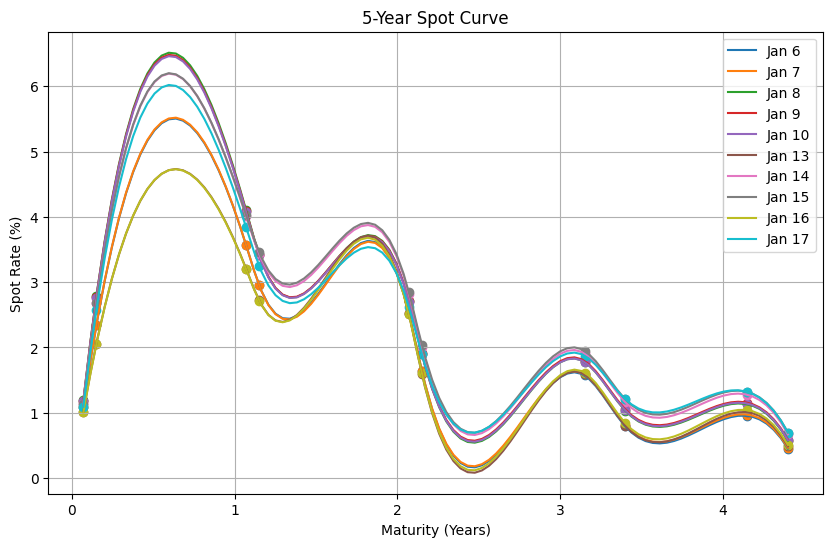

In [102]:
for day, bonds in bond_data_by_day.items():
    sorted_bonds = sorted(bonds, key=lambda x: x[2])  # Sorting by maturity
    maturities = [b[2] for b in sorted_bonds]
    spot_rates = compute_spot_rates(sorted_bonds)

    # Applying MA smoothing to reduce volatility
    smoothed_spot_rates = np.convolve(spot_rates, np.ones(3)/3, mode='same')

    spot_curves[day] = (maturities, smoothed_spot_rates)

# Plot spot curves for each day with cubic spline interpolation to smoothen out the curve.
plt.figure(figsize=(10, 6))

for day, (maturities, spots) in spot_curves.items():
    sorted_indices = np.argsort(maturities)
    sorted_maturities = np.array(maturities)[sorted_indices]
    sorted_spots = np.array(spots)[sorted_indices]

    cs = CubicSpline(sorted_maturities, sorted_spots)
    smooth_x = np.linspace(min(sorted_maturities), max(sorted_maturities), 100)
    smooth_y = cs(smooth_x)

    plt.plot(smooth_x, smooth_y, linestyle='-', label=day)
    plt.scatter(sorted_maturities, sorted_spots, marker='o')

plt.xlabel("Maturity (Years)")
plt.ylabel("Spot Rate (%)")
plt.title("5-Year Spot Curve")
plt.legend()
plt.grid()
plt.show()


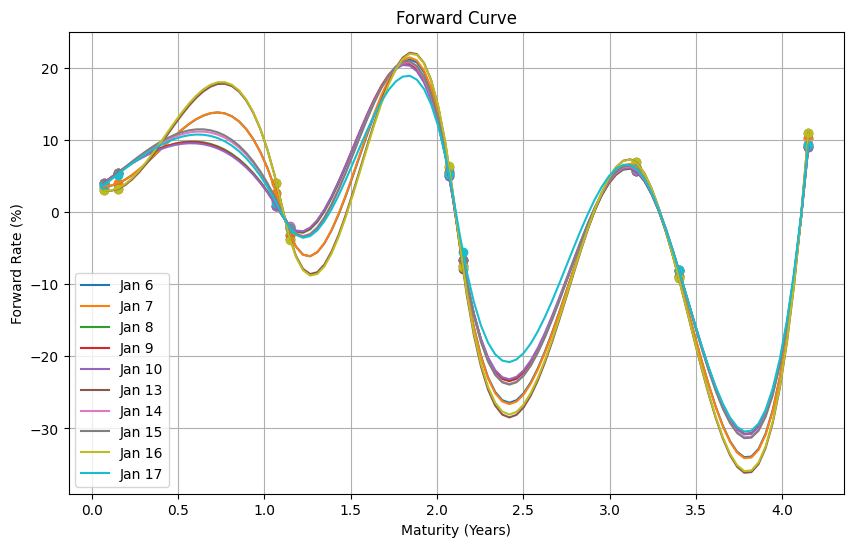

In [101]:
for day, bonds in bond_data_by_day.items():
    sorted_bonds = sorted(bonds, key=lambda x: x[2])  # Sorting by maturity
    maturities = [b[2] for b in sorted_bonds]
    spot_rates = compute_spot_rates(sorted_bonds)

    # Computing forward rates
    forward_rates = compute_forward_rates(spot_rates, maturities)

    spot_curves[day] = (maturities, spot_rates)
    forward_curves[day] = (maturities[:-1], forward_rates)

# Plot forward curves for each day using cubic spline interpolation to smoothen out the curve.
plt.figure(figsize=(10, 6))

for day, (maturities, forwards) in forward_curves.items():
    sorted_indices = np.argsort(maturities)
    sorted_maturities = np.array(maturities)[sorted_indices]
    sorted_forwards = np.array(forwards)[sorted_indices]

    cs = CubicSpline(sorted_maturities, sorted_forwards)
    smooth_x = np.linspace(min(sorted_maturities), max(sorted_maturities), 100)
    smooth_y = cs(smooth_x)

    plt.plot(smooth_x, smooth_y, linestyle='-', label=day)
    plt.scatter(sorted_maturities, sorted_forwards, marker='o')

plt.xlabel("Maturity (Years)")
plt.ylabel("Forward Rate (%)")
plt.title("Forward Curve")
plt.legend()
plt.grid()
plt.show()

In [103]:
import pandas as pd
import numpy as np

# Loading the xlsx file
file_path = "/content/SelectedBonds.xlsx"
xls = pd.ExcelFile(file_path)

# Loading the data from the first sheet
df = pd.read_excel(xls, sheet_name='Sheet1')

# Extracting relevant columns (bond prices over days)
bond_prices = df.iloc[:, 5:].T  # Transpose to have days as rows and bonds as columns
bond_prices.columns = df["Name"]  # Assign bond names as column headers

# Compute daily log-returns
log_returns = np.log(bond_prices / bond_prices.shift(1)).dropna()

# Compute the covariance matrix for bond yield log-returns
cov_matrix_yield = log_returns.cov()

# Extract bond maturities
maturities = pd.to_datetime(df["Maturity Date"], format="%m/%d/%Y")

# Convert to year (in terms of decimals) from today (Take Jan 6 as base for calculation)
base_date = pd.Timestamp("2025-01-06")
years_to_maturity = (maturities - base_date).dt.days / 365.25

# Organize bonds by maturity for forward rate calculation
df["Years to Maturity"] = years_to_maturity
df_sorted = df.sort_values("Years to Maturity")

# Select bonds for forward rates (1yr-1yr, 1yr-2yr, etc.)
bond_prices_sorted = bond_prices.loc[:, df_sorted["Name"]]

# Compute forward rates
forward_rates = pd.DataFrame(index=bond_prices.index[:-1])  # Forward rates computed between different days

for i in range(1, 5):
    t1, t2 = i, i + 1  # 1-year intervals
    bond_t1 = bond_prices_sorted.iloc[:, t1]  # Bond with maturity t1
    bond_t2 = bond_prices_sorted.iloc[:, t2]  # Bond with maturity t2
    forward_rate = (bond_t1 / bond_t2) ** (1 / (t2 - t1)) - 1
    forward_rates[f"1yr-{i}yr"] = forward_rate

# Compute log-returns for forward rates
log_returns_forward = np.log(forward_rates / forward_rates.shift(1)).dropna()

# Compute covariance matrix for forward rate log-returns
cov_matrix_forward = log_returns_forward.cov()

# Compute eigenvalues and eigenvectors for both covariance matrices
eigvals_yield, eigvecs_yield = np.linalg.eig(cov_matrix_yield)
eigvals_forward, eigvecs_forward = np.linalg.eig(cov_matrix_forward)

# Export prep
eigvals_df = pd.DataFrame({
    "Yield Eigenvalues": eigvals_yield,
    "Forward Eigenvalues": np.pad(eigvals_forward, (0, len(eigvals_yield) - len(eigvals_forward)), mode='constant')
})

eigvecs_yield_df = pd.DataFrame(eigvecs_yield, columns=[f"EigVec_{i+1}" for i in range(len(eigvals_yield))])
eigvecs_forward_df = pd.DataFrame(eigvecs_forward, columns=[f"EigVec_{i+1}" for i in range(len(eigvals_forward))])

# Save to Excel
output_file = "Covariance_Matrices.xlsx"
with pd.ExcelWriter(output_file) as writer:
    cov_matrix_yield.to_excel(writer, sheet_name="Yield Covariance")
    cov_matrix_forward.to_excel(writer, sheet_name="Forward Covariance")
    eigvals_df.to_excel(writer, sheet_name="Eigenvalues")
    eigvecs_yield_df.to_excel(writer, sheet_name="Yield Eigenvectors")
    eigvecs_forward_df.to_excel(writer, sheet_name="Forward Eigenvectors")

# Display results
print("Covariance matrices and eigenvalues/eigenvectors saved to", output_file)


Covariance matrices and eigenvalues/eigenvectors saved to Covariance_Matrices.xlsx
